In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import re
import gensim
from collections import Counter

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn import metrics

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D

%matplotlib inline
import helper_function as hf

Using TensorFlow backend.


# Loading descriptions

In [2]:
with open('data/steam_game_descriptions_2.txt', 'r') as f:
  reader = csv.reader(f)
  descriptions = list(reader)

In [3]:
descriptions = descriptions[0]

# Loading targets

In [4]:
with open('data/steam_complete_tag_list_2.txt', 'r') as f:
  reader = csv.reader(f)
  tag_names = list(reader)

In [5]:
tag_names = tag_names[0]

In [6]:
y_mat = np.load('data/steam_tag_metrix_3.npy')

# Looking at the distribution across genres

In [7]:
aggregate = sum(y_mat)
sort_idx = sorted(range(len(aggregate)), key=lambda k: aggregate[k], reverse=True)
y_label_names = [tag_names[idx] for idx in sort_idx]

In [8]:
for idx, sorted_idx in enumerate(sort_idx[:15]):
    print(idx, tag_names[sorted_idx], aggregate[sorted_idx])

0 Indie 26171.0
1 Action 19256.0
2 Adventure 15045.0
3 Casual 13989.0
4 Simulation 12940.0
5 Strategy 12328.0
6 RPG 9228.0
7 Singleplayer 8076.0
8 Multiplayer 4637.0
9 Great Soundtrack 3764.0
10 Free to Play 3662.0
11 Puzzle 3660.0
12 Atmospheric 3212.0
13 2D 3207.0
14 Early Access 2791.0


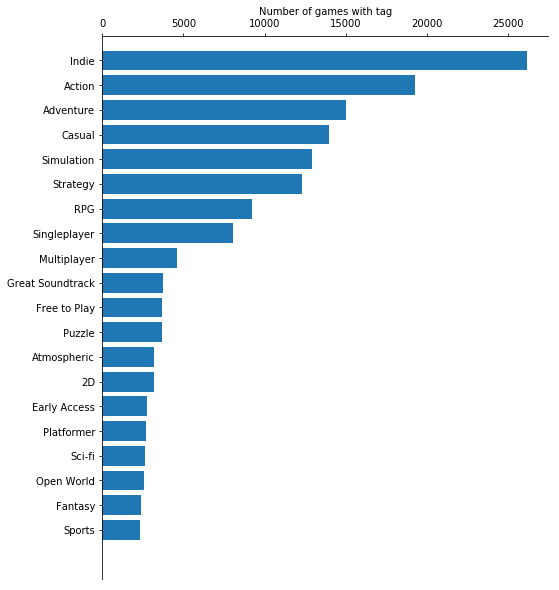

In [9]:
hf.plot_top_tags_barplot(y_label_names, aggregate, sort_idx, 20)

# Looking at a subset of the genres

Since many of the the tags, such as multiplayer, singleplayer, and free to play could belong to any genre, I have selected a subset of that tags that I bilieve will be easier and more interesting to predict.

In [10]:
tag_subset_idx = [13, 16, 18, 25, 40, 53, 61, 67, 71]
idx_of_selected_tags = []
tag_names_subset = []
for tag_idx in tag_subset_idx:
    idx = sort_idx[tag_idx]
    idx_of_selected_tags.append(idx)
    print(tag_names[idx], aggregate[idx])
    tag_names_subset.append(tag_names[idx])

2D 3207.0
Sci-fi 2623.0
Fantasy 2390.0
Horror 2068.0
Comedy 1540.0
Cute 915.0
Hidden Object 804.0
Realistic 682.0
Action RPG 641.0


# Subsetting the data

## Getting the descriptions with one or more of the subtags

In [11]:
relevant_description_idx = []
description_subset = []
for idx, row in enumerate(y_mat):
    if np.sum(row[idx_of_selected_tags])>0:
        relevant_description_idx.append(idx)
        description_subset.append(descriptions[idx])

Write code to filter out game descriptions that have no information

In [12]:
len(relevant_description_idx)

11244

An example of a game

In [13]:
print(descriptions[relevant_description_idx[2]])
tag_indices = np.where(y_mat[relevant_description_idx[2],:]>0)[0]
for idx in tag_indices:
    print(tag_names[idx])

... 300 years after Aziraal has been banished, a brother and sister are drawn into the conflict which has flared up between the Orcs and the free world. Kyra, the hero's younger sister, suddenly disappears in mysterious circumstances.«...If my family really belongs to the chosen ones, why then have we always been as poor as church mice?
Action
Singleplayer
Multiplayer
RPG
Open World
Fantasy
Third Person
Adventure
Medieval
Action RPG
Story Rich


In [14]:
idx_of_selected_tags

[72, 21, 25, 13, 9, 118, 116, 185, 29]

In [15]:
for idx in idx_of_selected_tags:
    print(np.sum(y_mat[:, idx]))

3207.0
2623.0
2390.0
2068.0
1540.0
915.0
804.0
682.0
641.0


In [16]:
y = np.zeros( (len(description_subset), len(idx_of_selected_tags)) )
for i, idx in enumerate(relevant_description_idx):
    y[i,:] = y_mat[idx, idx_of_selected_tags]

# Going from words to a vector

In [17]:
def sentence_to_point(description, word_model):
    words = description.split()
    game_vec = np.zeros((300,))
    for word in words:
        if word in word_model.vocab:
            word_vec = word_model.wv[word]
            game_vec = np.add(game_vec, word_vec)
    return game_vec

In [18]:
word_model = gensim.models.KeyedVectors.load_word2vec_format('./models/GoogleNews-vectors-negative300.bin', binary=True)  

In [19]:
X = np.zeros( (len(description_subset), 300) )
for idx, description in enumerate(description_subset):
    game_vec = sentence_to_point(description, word_model)
    X[idx,:] = game_vec

# Beginning machine learning

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
model = LogisticRegression()
model_collection = []
for genre in range(0,len(idx_of_selected_tags)): 
    clf_clone = clone(model)
    clf_clone.fit(X_train, y_train[:, genre])
    model_collection.append(clf_clone)

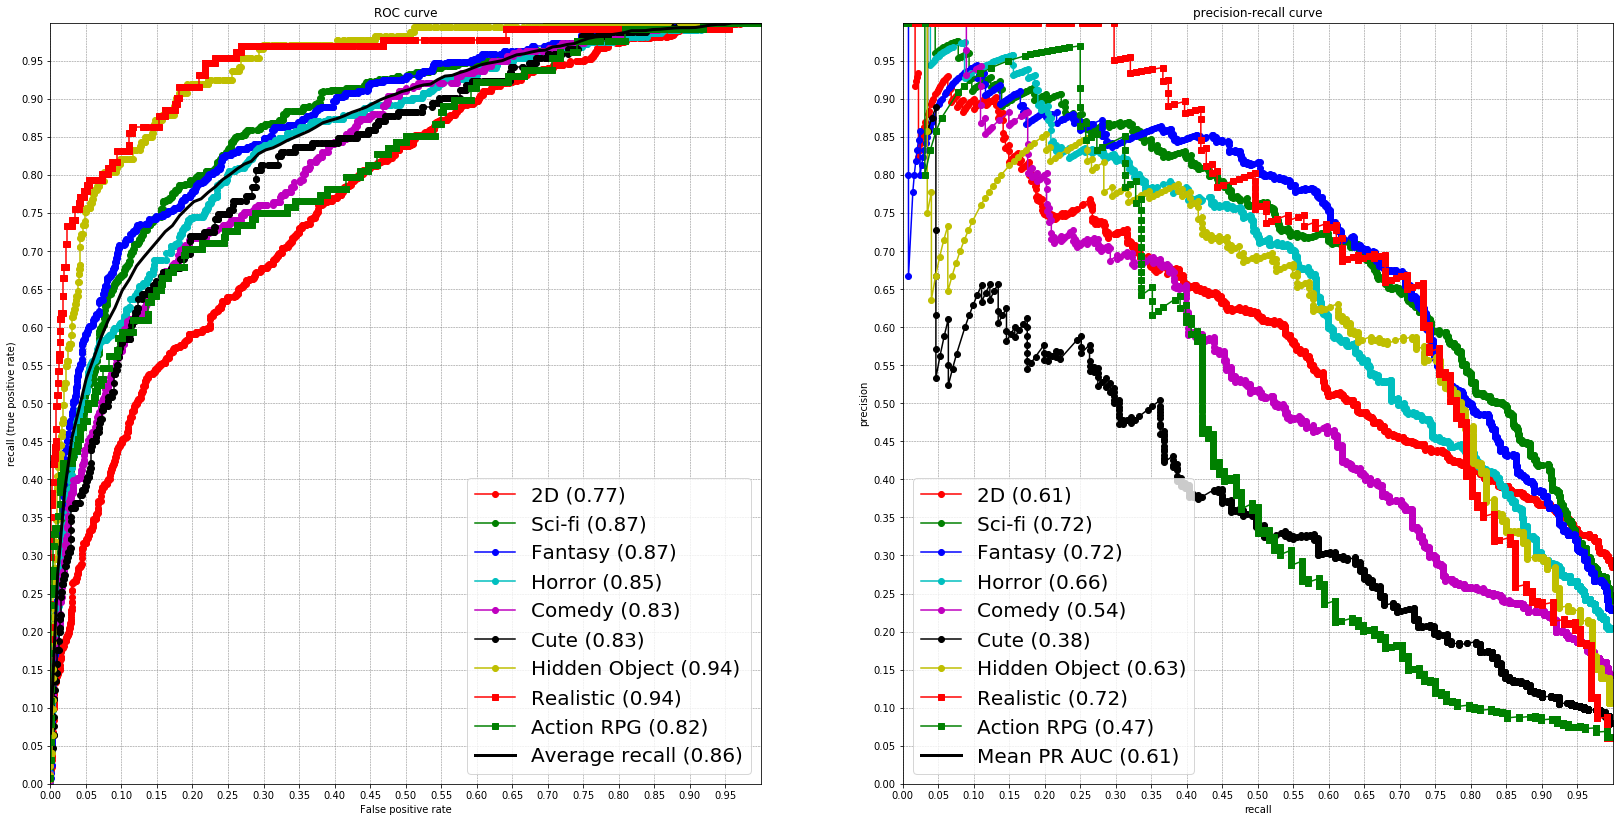

In [22]:
hf.make_roc_pr_plot(X_test, y_test, model_collection, tag_names_subset)

# Trying it out

In [23]:
example = 'In a strange future darkness lurks behind every star. With the sun about to collapse, you must find a way for the human rance to survive.'
#example = 'Madness has spread in the town. Zombies are everywhere and blood floods in the streets.'
game_vec = sentence_to_point(example, word_model)

In [24]:
pred_list = []
for idx, clf in enumerate(model_collection):
    pred = clf.predict_proba(game_vec.reshape(1, -1))
    pred_list.append(pred[:,1])

In [25]:
sort_idx = sorted(range(len(pred_list)), key=lambda k: pred_list[k], reverse=True)
my_list = [(pred_list[idx], tag_names_subset[idx]) for idx in sort_idx]
my_list

[(array([ 0.53563527]), 'Horror'),
 (array([ 0.22879144]), 'Fantasy'),
 (array([ 0.17508693]), 'Sci-fi'),
 (array([ 0.10135678]), '2D'),
 (array([ 0.063123]), 'Hidden Object'),
 (array([ 0.0307062]), 'Cute'),
 (array([ 0.0207262]), 'Action RPG'),
 (array([ 0.00401695]), 'Comedy'),
 (array([  1.40052505e-05]), 'Realistic')]

# Using neural networds to do the classification

The network should be given a string of words, and not the word2vec embedding, which was used in the previous section

## Cleaning the strings a bit

In [26]:
def clean_string(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)
    # Replace numbers by x
    string = re.sub("\d", "x", string) 
    string.strip().lower()
    string = remove_stop_words(string)
    return string

def remove_stop_words(description):
    word_list = description.split()
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    description = ' '.join(filtered_words)
    return description

In [27]:
cleaned_description = []
for desc in description_subset:
    desc = clean_string(desc)
    cleaned_description.append(desc)

# Counting the occourence of words to get top N words

In [28]:
corpus = ' '.join(cleaned_description)
c = Counter(corpus.split())

The corpus contains the following number of words:

In [29]:
len(c)

30481

For the embedding we want to use only some of the words. We select the top 5000 words in this case.

In [30]:
n_words = 5000
top_n_words = c.most_common(n_words)

In [31]:
top_n_words[:5]

[('The', 2746), ('game', 2612), ('new', 1652), ('world', 1429), ('A', 1148)]

In [32]:
top_n_words_dict = {}
for idx, item in enumerate(top_n_words):
    word = item[0]
    top_n_words_dict[word] = idx

In [33]:
def embedding_description(desc, top_n_words_dict):
    game_embedding = []
    for idx, word in enumerate(desc.split()):
        if word in top_n_words_dict:
            word_idx = top_n_words_dict[word]
            game_embedding.append(word_idx)
        else:
            game_embedding.append(0)
    return game_embedding

In [34]:
embedded_descriptions = []
for desc in cleaned_description:
    #game_embedding = np.zeros((len(desc.split())))
    game_embedding = []
    for idx, word in enumerate(desc.split()):
        if word in top_n_words_dict:
            word_idx = top_n_words_dict[word]
            game_embedding.append(word_idx)
        else:
            game_embedding.append(0)
    embedded_descriptions.append(game_embedding)

In [35]:
embedded_descriptions = np.array(embedded_descriptions)

## Training a netword based on the embedding

In [36]:
X_train, X_test, y_train, y_test = train_test_split(embedded_descriptions, y, test_size=0.2)

In [37]:
type(X_train)

numpy.ndarray

In [38]:
X_train.shape

(8995,)

In [39]:
maxlen = 70

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Pad sequences (samples x time)
X_train shape: (8995, 70)
X_test shape: (2249, 70)


In [40]:
# Embedding
max_features = n_words
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 50

# Training
batch_size = 32
epochs = 10

In [41]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.input_shape)
print(model.summary())

(None, 70)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 128)           640000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 66, 64)            41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         

In [42]:
nn_model_collection = []
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
for genre in range(0,len(idx_of_selected_tags)): 
    model_genre = Sequential()
    model_genre.add(Embedding(max_features, embedding_size, input_length=maxlen))
    model_genre.add(Dropout(0.25))
    model_genre.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model_genre.add(MaxPooling1D(pool_size=pool_size))
    model_genre.add(LSTM(lstm_output_size))
    model_genre.add(Dense(1))
    model_genre.add(Activation('sigmoid'))

    model_genre.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model_genre.fit(X_train, y_train[:, genre],
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(X_test, y_test[:, genre]))
    nn_model_collection.append(model_genre)

2208/2249 [============================>.] - ETA: 0s

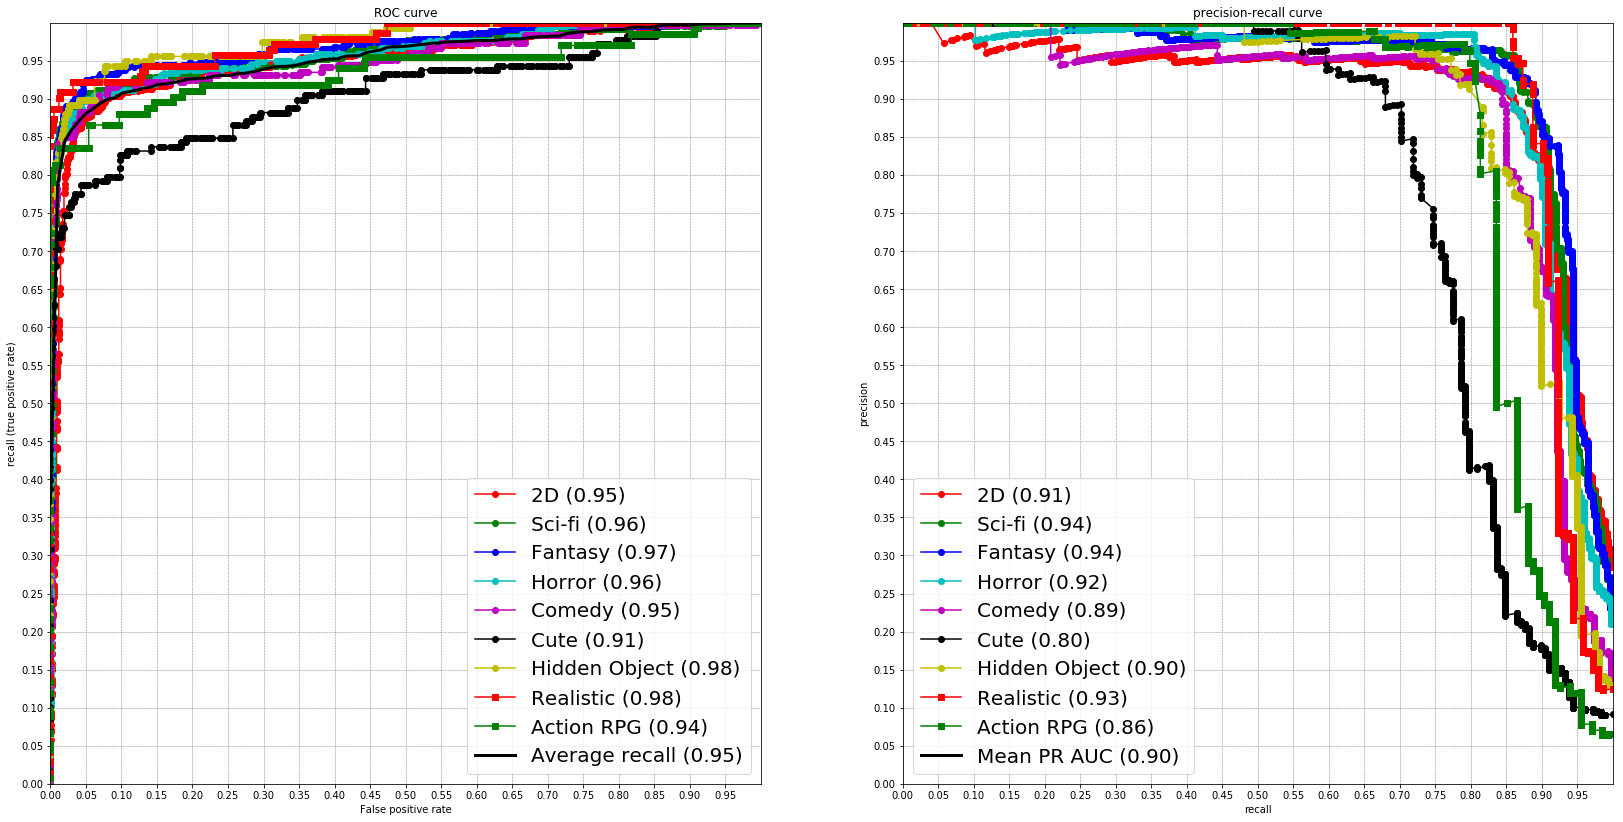

In [43]:
hf.make_roc_pr_plot(X_test, y_test, nn_model_collection, tag_names_subset)

## Trying out the network

In [44]:
def pre_process_for_nn(string):
    string = clean_string(string)
    embedded = embedding_description(string, top_n_words_dict)
    a = [0] * (70 - len(embedded))
    zero_padded_example = np.array(a + embedded).reshape(-1,70)
    return(zero_padded_example)

In [45]:
#example = 'In a strange future darkness lurks behind every star. With the sun about to collapse, you must find a way for the human rance to survive.'
example = 'Madness has spread in the town. Zombies are everywhere and blood floods in the streets.'
zero_padded_example = pre_process_for_nn(example)

In [46]:
pred_list = []
for idx, clf in enumerate(nn_model_collection):
    pred = clf.predict_proba(zero_padded_example)
    pred_list.append(pred)
    
sort_idx = sorted(range(len(pred_list)), key=lambda k: pred_list[k], reverse=True)
my_list = [(pred_list[idx], tag_names_subset[idx]) for idx in sort_idx]
my_list

1/1 [==============================] - 0s


[(array([[ 0.81701434]], dtype=float32), 'Horror'),
 (array([[ 0.4390564]], dtype=float32), 'Comedy'),
 (array([[ 0.00555613]], dtype=float32), '2D'),
 (array([[ 0.00389685]], dtype=float32), 'Hidden Object'),
 (array([[  8.09949706e-05]], dtype=float32), 'Action RPG'),
 (array([[  6.63782121e-05]], dtype=float32), 'Fantasy'),
 (array([[  5.08144694e-05]], dtype=float32), 'Cute'),
 (array([[  1.46722123e-05]], dtype=float32), 'Realistic'),
 (array([[  6.07181710e-06]], dtype=float32), 'Sci-fi')]

# Doing LSTM om the word2vec representation of the words

## Turning each word into a 300 dim vec

In [47]:
max_words = 0
for desc in description_subset:
    length = len(desc.split())
    if length > max_words: 
        max_words = length

In [48]:
def sentence_to_vec(description, max_words, word_model):
    sentence_vec = np.zeros( (300, max_words) )
    words = description.split()
    game_vec = np.zeros((300,))
    idx = 0
    for word in words:
        if word in word_model.vocab:
            word_vec = word_model.wv[word]
            sentence_vec[:, idx] = word_vec
            idx =+ 1
    return sentence_vec

In [49]:
X_embedded = np.zeros( (len(description_subset), max_words , 300) )
for idx, desc in  enumerate(description_subset):
    sentence_vec = sentence_to_vec(desc, max_words, word_model)
    X_embedded[idx, :, :] = np.transpose(sentence_vec)

In [50]:
np.shape(X_embedded)

(11244, 66, 300)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.2)

In [52]:
X_test.shape

(2249, 66, 300)

# Building a simple LSTM

In [53]:
word_vec_dim = 300

model = Sequential()
model.add(LSTM(max_words, input_shape=(max_words, word_vec_dim)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.input_shape)
print(model.summary())

(None, 66, 300)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 66)                96888     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 67        
Total params: 96,955
Trainable params: 96,955
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
history = model.fit(X_train,
                    y_train[:,0],
                    epochs=10,
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_test, y_test[:,0])
                   )

Train on 8995 samples, validate on 2249 samples
Epoch 1/10
8995/8995 [==============================] - 95s - loss: 0.6045 - acc: 0.7168 - val_loss: 0.6063 - val_acc: 0.7056
Epoch 2/10
8995/8995 [==============================] - 86s - loss: 0.5974 - acc: 0.7171 - val_loss: 0.6067 - val_acc: 0.7056
Epoch 3/10
8995/8995 [==============================] - 86s - loss: 0.5974 - acc: 0.7171 - val_loss: 0.6077 - val_acc: 0.7056
Epoch 4/10
8995/8995 [==============================] - 78s - loss: 0.5971 - acc: 0.7171 - val_loss: 0.6060 - val_acc: 0.7056
Epoch 5/10
8995/8995 [==============================] - 69s - loss: 0.5962 - acc: 0.7171 - val_loss: 0.6093 - val_acc: 0.7056
Epoch 6/10
8995/8995 [==============================] - 83s - loss: 0.5961 - acc: 0.7171 - val_loss: 0.6117 - val_acc: 0.7056
Epoch 7/10
8995/8995 [==============================] - 84s - loss: 0.5968 - acc: 0.7171 - val_loss: 0.6066 - val_acc: 0.7056
Epoch 8/10
8995/8995 [==============================] - 83s - loss: 0.

# The guide from Machine Learning mastery on IMDB data

The CNN LSTM neural network below is taken directly from: https://github.com/fchollet/keras/blob/master/examples/imdb_cnn_lstm.py